In [1]:
%matplotlib widget

## Imports

Importing the saqc package:

In [2]:
import saqc

We use pandas package to parse the data from csv file and generate timestamps:

In [3]:
import pandas as pd

We use numpies representation of invalid (nan) values and infinetly large values (inf): 

In [4]:
from numpy import nan, inf 

we will use the flagging decorator to manually add a flagging-function to the saqc functions catalogue:

In [5]:
from saqc.core.register import flagging

set an plot figure size appropiate for jupyter

In [6]:
saqc.lib.plotting.FIG_KWARGS["figsize"] = (11, 6)

## We add a function to the saqc methods catalogue manually

* the method is not yet part of the current PyPi version:
* its definition may look a little cryptic: its used to flag all data in dependence of a generic condition

In [7]:
@flagging()
def rejectGeneric(qc, field, flag_label, cond, *args, **kwargs):
    qc = qc.flagGeneric(field, func=lambda x: pd.Series(cond(isflagged(x, flag_label)) , index=x.index), *args, **kwargs)
    return qc

## **IAGOS-ICH** near real time flagging scheme


|Flag Index | IAGOS State of Reliability of Data|
|------|---------|
|0 | Good |
|2 | Limited |
|3 | Erroneous |
|7 | Missing Value |

* tests are applied in a specific order
* the flag assigned by a test can not override a higher value from a previous test. 

We modify the existing flagging scheme from the UFZ - Data Management Portal:

In [8]:
from saqc.core.translation.basescheme import MappingScheme
    
# The flags names internally are represented as float numbers
FORWARD = {
    'Not Validated': -inf,
    'Good': 0,
    'Limited': 2,
    'Erroneous': 3,
    'Missing': 255
}

# internal values get translated back to IAGOS scheme names
# in addition, nan values (values that have not been tested by any test) are forwarded as 'Unflagged'
BACKWARD = {
    nan: 'Not Validated',
    -inf: 'Not Validated',
    0: 'Good',     
    2: 'Limited',
    3: 'Erroneous',
    255: 'Missing'
}

class IAGOScheme(MappingScheme):


    def __init__(self):
        super().__init__(FORWARD, BACKWARD)

    def toExternal(self, flags, attrs = None, **kwargs):
        
        tflags = super().toExternal(flags, attrs=attrs)
        out = pd.DataFrame(
            index=tflags.to_pandas().index,
            columns=pd.MultiIndex.from_product([flags.columns, ("flag", "saqc-function", "iagos-function")]),
        )

        for field in tflags.columns:
            df = pd.DataFrame(
                {
                    "flag": tflags[field],
                    "saqc-function": "",
                    "iagos-function": ""
                },
            )

            history = flags.history[field]
            for col in history.columns:
                valid = (history.hist[col] != UNFLAGGED) & history.hist[col].notna()
                meta = history.meta[col]    
                keywords = meta.get("kwargs", {})
                df.loc[valid, "saqc-function"] = meta.get("func", "unknown")
                df.loc[valid, "iagos-function"] = keywords.get("comment", "")
            
            out[field] = df

        return out

## Data import

In [9]:
# using pandas csv reader to import the data. fist column contains dates and is parsed as such
data = pd.read_csv('data/IAGOS.csv', parse_dates=[0], index_col=0)
data

lon      lat    air_press     baro_alt  \
UTC_time                                                           
2017-01-02 15:56:04  121.2202  25.0763  1016.299988 -3048.000000   
2017-01-02 15:56:08  121.2213  25.0772  1016.400024 -3048.000000   
2017-01-02 15:56:12  121.2230  25.0782  1016.500000 -3048.000000   
2017-01-02 15:56:16  121.2243  25.0792  1016.700012 -3048.000000   
2017-01-02 15:56:20  121.2257  25.0806  1016.799988 -3048.000000   
...                       ...      ...          ...          ...   
2017-01-03 04:57:09   16.5676  48.1114  1000.299988   107.599998   
2017-01-03 04:57:13   16.5653  48.1122  1000.299988   107.900002   
2017-01-03 04:57:17   16.5627  48.1131  1001.099976   100.300003   
2017-01-03 04:57:21   16.5607  48.1138  1000.900024   103.300003   
2017-01-03 04:57:25   16.5585  48.1145  1000.599976   104.900002   

                     air_stag_temp_AC  air_stag_temp_P1  air_stag_temp_P1_err  \
UTC_time                                                                        
2017-01-02 15:56:04        293.950012        293.570007                  0.50   
2017-01-02 15:56:08        293.950012        293.950012                  0.50   
2017-01-02 15:56:12        294.350006        293.679993                  0.47   
2017-01-02 15:56:16        294.649994        293.160004                  0.45   
2017-01-02 15:56:20        295.149994        294.790009                  0.42   
...                               ...               ...                   ...   
2017-01-03 04:57:09        275.950012        275.399994                  0.37   
2017-01-03 04:57:13        275.950012        275.059998                  0.37   
2017-01-03 04:57:17        275.350006        274.279999                  0.45   
2017-01-03 04:57:21        275.149994        273.459991                  0.45   
2017-01-03 04:57:25        274.950012     999999.000000             999999.00   

                       air_temp_P1  air_temp_P1_err      RHL_P1  \
UTC_time                                                          
2017-01-02 15:56:04     292.890015             0.50       1.268   
2017-01-02 15:56:08     292.959991             0.50       1.274   
2017-01-02 15:56:12     292.420013             0.47       1.269   
2017-01-02 15:56:16     291.540009             0.45       1.269   
2017-01-02 15:56:20     292.890015             0.42       1.257   
...                            ...              ...         ...   
2017-01-03 04:57:09     273.350006             0.38       0.799   
2017-01-03 04:57:13     273.140015             0.38       0.801   
2017-01-03 04:57:17     272.859985             0.45       0.810   
2017-01-03 04:57:21     272.320007             0.45       0.828   
2017-01-03 04:57:25  999999.000000        999999.00  999999.000   

                        RHL_P1_err  H2O_gas_P1  H2O_gas_P1_err  Volt_RH_P1  \
UTC_time                                                                     
2017-01-02 15:56:04  999999.000000      999999   999999.000000       9.944   
2017-01-02 15:56:08  999999.000000      999999   999999.000000       9.844   
2017-01-02 15:56:12  999999.000000      999999   999999.000000       9.719   
2017-01-02 15:56:16  999999.000000      999999   999999.000000       9.576   
2017-01-02 15:56:20  999999.000000      999999   999999.000000       9.404   
...                            ...         ...             ...         ...   
2017-01-03 04:57:09       0.036569        4978      290.705750       6.031   
2017-01-03 04:57:13       0.036686        4915      287.341888       6.086   
2017-01-03 04:57:17       0.042354        4866      310.068848       6.247   
2017-01-03 04:57:21       0.043392        4782      305.615021       6.475   
2017-01-03 04:57:25  999999.000000      999999   999999.000000  999999.000   

                      Volt_T_P1  air_speed  air_temp_AC  MACH_NO_calc  \
UTC_time                                                                
2017-01-02 15:56:04       5.042  37.000000   293.14999

# Test 1: iagos_rh_impossibleTimeRPSetQC

* timestamp monotony check
* is timestamp monotonically increasing?
* are there dublicated entries
* not really possible to handle and backtrack inside saqc, we skip that for now:

In [10]:
# sorting the index
data = data.sort_index()
# forgetting dublicated entries:
data = data[~data.index.duplicated()]

## SaQC object instantiation

* we instantiate an saqc object rom the data with the flagging scheme

In [11]:
qc = saqc.SaQC(data, scheme=IAGOScheme())
qc.data.to_pandas()

lon      lat    air_press     baro_alt  \
UTC_time                                                           
2017-01-02 15:56:04  121.2202  25.0763  1016.299988 -3048.000000   
2017-01-02 15:56:08  121.2213  25.0772  1016.400024 -3048.000000   
2017-01-02 15:56:12  121.2230  25.0782  1016.500000 -3048.000000   
2017-01-02 15:56:16  121.2243  25.0792  1016.700012 -3048.000000   
2017-01-02 15:56:20  121.2257  25.0806  1016.799988 -3048.000000   
...                       ...      ...          ...          ...   
2017-01-03 04:57:09   16.5676  48.1114  1000.299988   107.599998   
2017-01-03 04:57:13   16.5653  48.1122  1000.299988   107.900002   
2017-01-03 04:57:17   16.5627  48.1131  1001.099976   100.300003   
2017-01-03 04:57:21   16.5607  48.1138  1000.900024   103.300003   
2017-01-03 04:57:25   16.5585  48.1145  1000.599976   104.900002   

                     air_stag_temp_AC  air_stag_temp_P1  air_stag_temp_P1_err  \
UTC_time                                                                        
2017-01-02 15:56:04        293.950012        293.570007                  0.50   
2017-01-02 15:56:08        293.950012        293.950012                  0.50   
2017-01-02 15:56:12        294.350006        293.679993                  0.47   
2017-01-02 15:56:16        294.649994        293.160004                  0.45   
2017-01-02 15:56:20        295.149994        294.790009                  0.42   
...                               ...               ...                   ...   
2017-01-03 04:57:09        275.950012        275.399994                  0.37   
2017-01-03 04:57:13        275.950012        275.059998                  0.37   
2017-01-03 04:57:17        275.350006        274.279999                  0.45   
2017-01-03 04:57:21        275.149994        273.459991                  0.45   
2017-01-03 04:57:25        274.950012     999999.000000             999999.00   

                       air_temp_P1  air_temp_P1_err      RHL_P1  \
UTC_time                                                          
2017-01-02 15:56:04     292.890015             0.50       1.268   
2017-01-02 15:56:08     292.959991             0.50       1.274   
2017-01-02 15:56:12     292.420013             0.47       1.269   
2017-01-02 15:56:16     291.540009             0.45       1.269   
2017-01-02 15:56:20     292.890015             0.42       1.257   
...                            ...              ...         ...   
2017-01-03 04:57:09     273.350006             0.38       0.799   
2017-01-03 04:57:13     273.140015             0.38       0.801   
2017-01-03 04:57:17     272.859985             0.45       0.810   
2017-01-03 04:57:21     272.320007             0.45       0.828   
2017-01-03 04:57:25  999999.000000        999999.00  999999.000   

                        RHL_P1_err  H2O_gas_P1  H2O_gas_P1_err  Volt_RH_P1  \
UTC_time                                                                     
2017-01-02 15:56:04  999999.000000      999999   999999.000000       9.944   
2017-01-02 15:56:08  999999.000000      999999   999999.000000       9.844   
2017-01-02 15:56:12  999999.000000      999999   999999.000000       9.719   
2017-01-02 15:56:16  999999.000000      999999   999999.000000       9.576   
2017-01-02 15:56:20  999999.000000      999999   999999.000000       9.404   
...                            ...         ...             ...         ...   
2017-01-03 04:57:09       0.036569        4978      290.705750       6.031   
2017-01-03 04:57:13       0.036686        4915      287.341888       6.086   
2017-01-03 04:57:17       0.042354        4866      310.068848       6.247   
2017-01-03 04:57:21       0.043392        4782      305.615021       6.475   
2017-01-03 04:57:25  999999.000000      999999   999999.000000  999999.000   

                      Volt_T_P1  air_speed  air_temp_AC  MACH_NO_calc  \
UTC_time                                                                
2017-01-02 15:56:04       5.042  37.000000   293.14999

In [12]:
qc.flags['air_press']

flag saqc-function iagos-function
UTC_time                                                       
2017-01-02 15:56:04  Not Validated                             
2017-01-02 15:56:08  Not Validated                             
2017-01-02 15:56:12  Not Validated                             
2017-01-02 15:56:16  Not Validated                             
2017-01-02 15:56:20  Not Validated                             
...                            ...           ...            ...
2017-01-03 04:57:09  Not Validated                             
2017-01-03 04:57:13  Not Validated                             
2017-01-03 04:57:17  Not Validated                             
2017-01-03 04:57:21  Not Validated                             
2017-01-03 04:57:25  Not Validated                             

[11684 rows x 3 columns]

# Test 2: iagos_rh_isnanRPPPQC  

* assign NaN values the missing flag
* if fill value is not already replaced by NaN, do it here

In [13]:
for v in qc.data.columns:
    qc = qc.processGeneric(v, func=lambda x: x.replace(999999, nan))

In [14]:
qc.data.to_pandas()

lon      lat    air_press     baro_alt  \
UTC_time                                                           
2017-01-02 15:56:04  121.2202  25.0763  1016.299988 -3048.000000   
2017-01-02 15:56:08  121.2213  25.0772  1016.400024 -3048.000000   
2017-01-02 15:56:12  121.2230  25.0782  1016.500000 -3048.000000   
2017-01-02 15:56:16  121.2243  25.0792  1016.700012 -3048.000000   
2017-01-02 15:56:20  121.2257  25.0806  1016.799988 -3048.000000   
...                       ...      ...          ...          ...   
2017-01-03 04:57:09   16.5676  48.1114  1000.299988   107.599998   
2017-01-03 04:57:13   16.5653  48.1122  1000.299988   107.900002   
2017-01-03 04:57:17   16.5627  48.1131  1001.099976   100.300003   
2017-01-03 04:57:21   16.5607  48.1138  1000.900024   103.300003   
2017-01-03 04:57:25   16.5585  48.1145  1000.599976   104.900002   

                     air_stag_temp_AC  air_stag_temp_P1  air_stag_temp_P1_err  \
UTC_time                                                                        
2017-01-02 15:56:04        293.950012        293.570007                  0.50   
2017-01-02 15:56:08        293.950012        293.950012                  0.50   
2017-01-02 15:56:12        294.350006        293.679993                  0.47   
2017-01-02 15:56:16        294.649994        293.160004                  0.45   
2017-01-02 15:56:20        295.149994        294.790009                  0.42   
...                               ...               ...                   ...   
2017-01-03 04:57:09        275.950012        275.399994                  0.37   
2017-01-03 04:57:13        275.950012        275.059998                  0.37   
2017-01-03 04:57:17        275.350006        274.279999                  0.45   
2017-01-03 04:57:21        275.149994        273.459991                  0.45   
2017-01-03 04:57:25        274.950012               NaN                   NaN   

                     air_temp_P1  air_temp_P1_err  RHL_P1  RHL_P1_err  \
UTC_time                                                                
2017-01-02 15:56:04   292.890015             0.50   1.268         NaN   
2017-01-02 15:56:08   292.959991             0.50   1.274         NaN   
2017-01-02 15:56:12   292.420013             0.47   1.269         NaN   
2017-01-02 15:56:16   291.540009             0.45   1.269         NaN   
2017-01-02 15:56:20   292.890015             0.42   1.257         NaN   
...                          ...              ...     ...         ...   
2017-01-03 04:57:09   273.350006             0.38   0.799    0.036569   
2017-01-03 04:57:13   273.140015             0.38   0.801    0.036686   
2017-01-03 04:57:17   272.859985             0.45   0.810    0.042354   
2017-01-03 04:57:21   272.320007             0.45   0.828    0.043392   
2017-01-03 04:57:25          NaN              NaN     NaN         NaN   

                     H2O_gas_P1  H2O_gas_P1_err  Volt_RH_P1  Volt_T_P1  \
UTC_time                                                                 
2017-01-02 15:56:04         NaN             NaN       9.944      5.042   
2017-01-02 15:56:08         NaN             NaN       9.844      5.061   
2017-01-02 15:56:12         NaN             NaN       9.719      5.043   
2017-01-02 15:56:16         NaN             NaN       9.576      5.014   
2017-01-02 15:56:20         NaN             NaN       9.404      5.091   
...                         ...             ...         ...        ...   
2017-01-03 04:57:09      4978.0      290.705750       6.031      4.116   
2017-01-03 04:57:13      4915.0      287.341888       6.086      4.099   
2017-01-03 04:57:17      4866.0      310.068848       6.247      4.072   
2017-01-03 04:57:21      4782.0      305.615021       6.475      4.031   
2017-01-03 04:57:25         NaN             NaN         NaN        NaN   

                     air_speed  air_temp_AC  MACH_NO_calc    RHI_P1  
UTC_time                                                             
2017-01-02 15:56:04  37.000000   2

In [15]:
for v in qc.data.columns:
    qc = qc.flagMissing(v, flag='Missing')

## Test 3:  iagos_rh_GlobalMinRPPPQC 

## 3a) test limited minima

In [16]:
for v in ['Volt_RH_P1', 'Volt_T_P1', 'air_press', 'air_temp_AC', 'air_temp_P1', 'RHL_P1']:
    qc = qc.flagRange(v, min=.5, dfilter='Limited', flag='Limited', label='minimum')

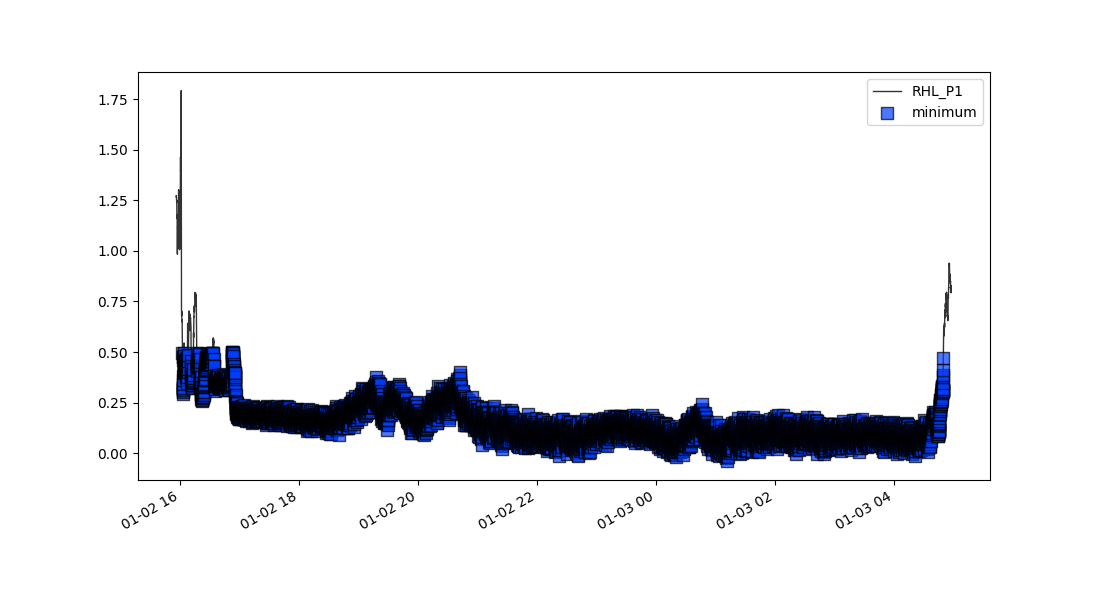

In [17]:
qc.plot("RHL_P1")

## 3b) test strict minima

In [18]:
for v in ['Volt_RH_P1', 'Volt_T_P1', 'air_press', 'air_temp_AC', 'air_temp_P1', 'RHL_P1']:
    qc = qc.rejectGeneric(v, 'minimum', cond=lambda x: x.sum()>(x.count()*.5), flag='Erroneous', label='50%+minimum', comment='iagos_rh_GlobalMinRPPPQC')   

In [19]:
qc.data.columns

Index(['lon', 'lat', 'air_press', 'baro_alt', 'air_stag_temp_AC',
       'air_stag_temp_P1', 'air_stag_temp_P1_err', 'air_temp_P1',
       'air_temp_P1_err', 'RHL_P1', 'RHL_P1_err', 'H2O_gas_P1',
       'H2O_gas_P1_err', 'Volt_RH_P1', 'Volt_T_P1', 'air_speed', 'air_temp_AC',
       'MACH_NO_calc', 'RHI_P1'],
      dtype='object')

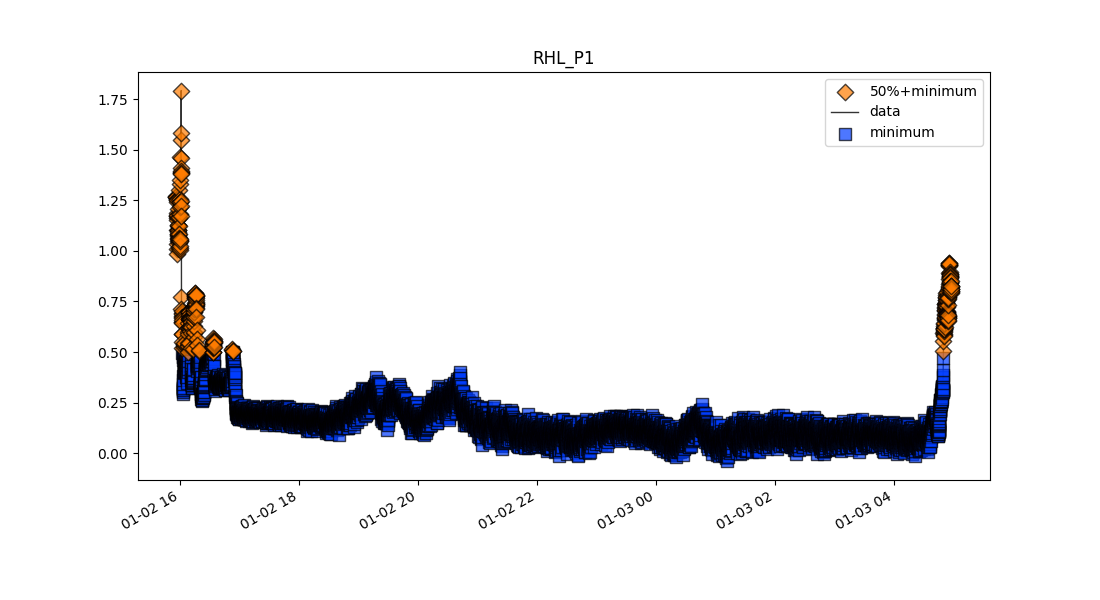

flag  saqc-function            iagos-function
UTC_time                                                               
2017-01-02 15:56:04  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:08  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:12  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:16  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:20  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
...                        ...            ...                       ...
2017-01-03 04:57:09  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:13  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:17  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:21  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:25    Missing    flagMissing                          

[11684 rows x 3 columns]

In [20]:
qc.plot('RHL_P1', mode='subplots')
qc.flags['RHL_P1']

# Test 4:  iagos_rh_GlobalMaxRPPPQC

## 4a) test limited maxima

In [21]:
qc = qc.flagRange('Volt_RH_P1', max=9.9, dfilter='Limited', flag='Limited', label='maximum_lim')
qc = qc.flagRange('RHL_P1', max=1.05, dfilter='Limited', flag='Limited', label='maximum_lim')

## 4b) test maxima

In [22]:
qc = qc.flagRange('Volt_T_P1', max=7, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('air_speed', max=544, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('air_press', max=1100, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('air_temp_AC', max=320, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('air_temp_P1', max=320, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('air_stag_temp_P1', max=310, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('RHL_P1', max=1.15, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('baro_alt', max=45932, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('lon', max=180, dfilter='Erroneous', flag='Erroneous', label='maximum')
qc = qc.flagRange('lat', max=90, dfilter='Erroneous', flag='Erroneous', label='maximum')

In [23]:
for v in ['Volt_T_P1','air_speed', 'air_press', 'air_temp_AC', 'air_temp_P1', 'air_stag_temp_P1', 'air_stag_temp_P1','RHL_P1', 'baro_alt', 'lon', 'lat']:
    qc = qc.rejectGeneric(v, 'maximum', cond=lambda x: x.sum()>(x.count()*.5),flag='Erroneous', label='50%+maximum')


# Test 8:  iagos_rh_SpikeOrNoiseRPPPQC 

* Spike test: if (|v(n) - 0.5*(v(n-1) + v(n+1))| - |v(n-1) - v(n+1)|)*0.5 exceeds thresh val

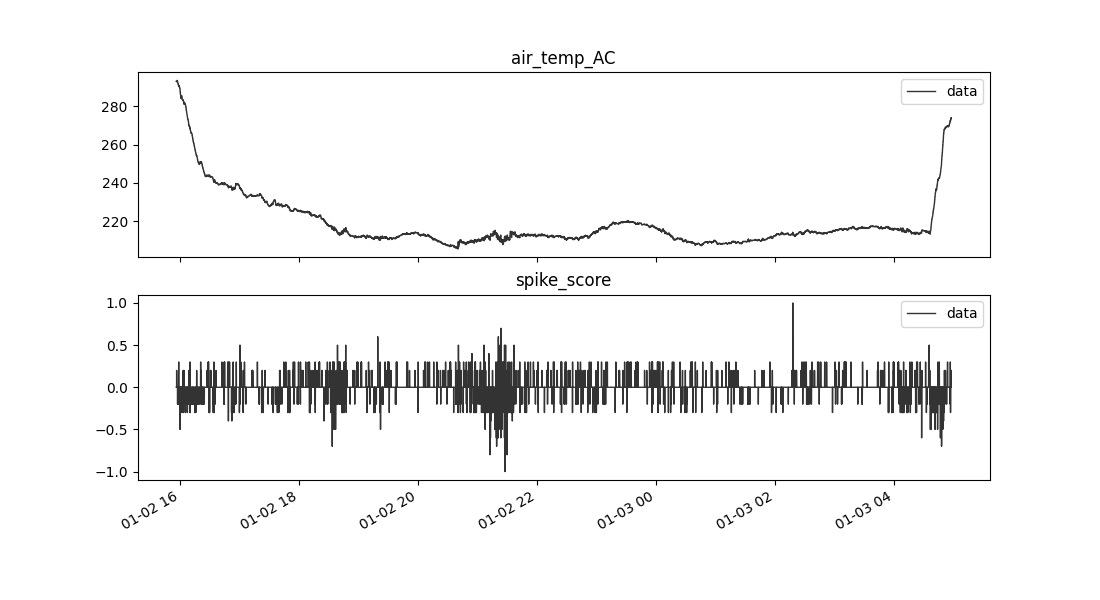

In [24]:
qc = qc.processGeneric('air_temp_AC', target='Vn-1', func=lambda x: x.shift(-1))
qc = qc.processGeneric('air_temp_AC', target='Vn+1', func=lambda x: x.shift(1))
qc = qc.processGeneric(['air_temp_AC', 'Vn-1', 'Vn+1'], target='spike_score', func=lambda x, y, z: (x - (y + z)*.5).abs() - 0.5*(y - z).abs())
qc.plot(['air_temp_AC','spike_score'], mode='subplots')

In [25]:
qc = qc.flagRange('spike_score', target='air_temp_AC', max=1.4)
qc= qc.flagGeneric('spike_score', target='air_temp_AC', func=lambda x: x>1.4, label='spike')

In [26]:
import numpy as np
qc= qc.rolling('air_temp_AC', target='stdv5', window=5, func=np.std, center=False)
qc= qc.rolling('stdv5', target='med_std5', window=5, func=np.median, center=False)

In [27]:
qc = qc.rolling('med_std5', target='run_av_med_std5', window=5, func=np.mean, center=False)
qc = qc.processGeneric(['run_av_med_std5', 'med_std5'], target='div_stat', func=lambda x, y: x.div(y))

In [28]:
qc = qc.flagGeneric(['med_std5', 'div_stat'], target='air_temp_AC', func=lambda x, y: (x >= .6) & (x < 1.2) & (y <= 0.4), label='Limited Noise')
qc = qc.flagGeneric(['med_std5', 'div_stat'], target='air_temp_AC', func=lambda x, y: (x < 0.02) & (y > 0.4), label='Maximum Noise', dfilter='Erroneous', flag='Erroneous')

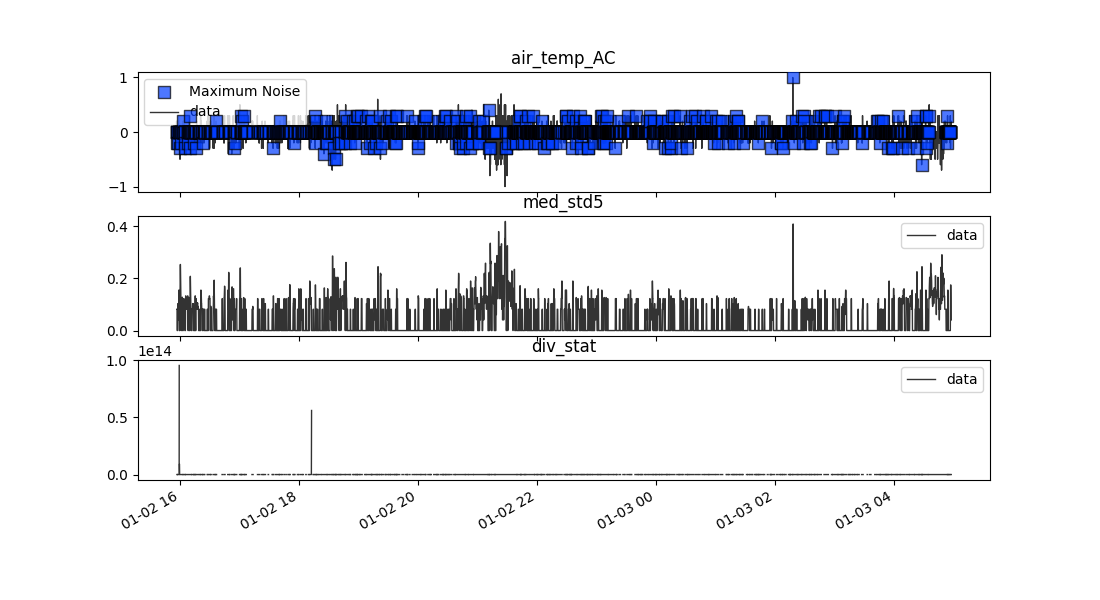

In [29]:
qc.plot(['air_temp_AC', 'med_std5', 'div_stat'], mode='subplots', ax_kwargs={'ncols':1})

In [30]:
qc.flags['RHL_P1']

flag  saqc-function            iagos-function
UTC_time                                                               
2017-01-02 15:56:04  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:08  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:12  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:16  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-02 15:56:20  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
...                        ...            ...                       ...
2017-01-03 04:57:09  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:13  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:17  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:21  Erroneous  rejectGeneric  iagos_rh_GlobalMinRPPPQC
2017-01-03 04:57:25    Missing    flagMissing                          

[11684 rows x 3 columns]